In [39]:
# Colab creates a virtual environment for you
# this is to install the pyro PPL in this environment.
# Pyro is a python library, not included by default in the list of preinstalled libraries in a Colab VM
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130
!pip install pyro_ppl

Looking in indexes: https://download.pytorch.org/whl/cu130


In [40]:
import numpy as np
import torch
import math
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC
import arviz
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns



In [41]:
"""
A Canti-lever is a beam, that is mounted on one side and free anywhere else.
Its volume and material properties define its natural frequencies analytically.
This function models this frequency.
You can also consider it as parameterized black-box model that describes our physical knowledge for the rest of the tutorial.
"""
def cantilever_natural_frequency(
    length: torch.tensor,  # L [m]
    width: torch.tensor,  # b [m]
    height: torch.tensor,  # h [m]
    density: torch.tensor,  # rho [kg/m^3]
    young_modulus: torch.tensor,  # E [Pa]
    mode=1,  # vibration mode number
):
    beta = {1: 1.875, 2: 4.694, 3: 7.855, 4: 10.996}[mode]

    A = width * height
    I = (width * height**3) / 12

    frequency = (beta**2 / (2 * torch.pi * length**2)) * torch.sqrt(
        (young_modulus * I) / (density * A)
    )

    return frequency

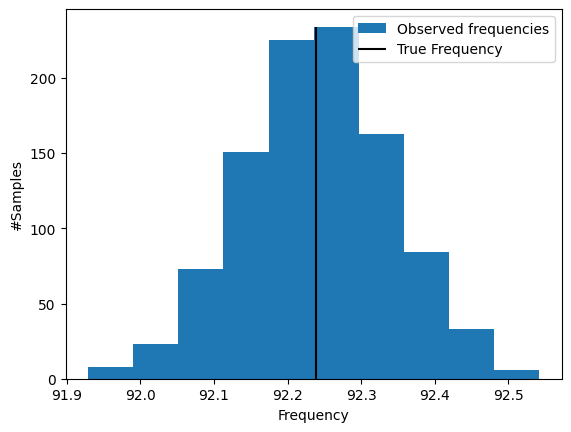

In [63]:
"""
Define a Canti-lever.
We assume that we have access to a limited number of noisy measurements of the frequency of the lever.
"""

length_true = torch.tensor(0.3)  # m
width_true = torch.tensor(0.02)  # m
height_true = torch.tensor(0.01)  # m
density_true = torch.tensor(7950.0)  # kg/m^3
young_modulus_true = torch.tensor(210e9)  # Pa
measurement_noise_true = 0.1

n_observations = 1000

# fix the seed for repeatability
torch.manual_seed(42)
true_natural_frequency = cantilever_natural_frequency(
    length_true, width_true, height_true, density_true, young_modulus_true
)
frequencies = dist.Normal(
    true_natural_frequency,
    measurement_noise_true,
).sample((n_observations,))

counts_per_pin = plt.hist(frequencies, label="Observed frequencies")
counts_per_pin = counts_per_pin[0]
plt.vlines([true_natural_frequency], ymin=0, ymax=counts_per_pin.max(), color="black", zorder=5, label="True Frequency")
plt.xlabel("Frequency")
plt.ylabel("#Samples")
plt.legend()

In [64]:
"""
Define the probabilistic model. We will only model the length as unknown and all other parameters fixed.
I.e. we will use inference to infer the length of the cantilever based on observations of its frequency.
"""

# create a physical canti-lever model, where all but the length parameter are fixed
cantilever_natural_frequency_length_only = partial(
    cantilever_natural_frequency,
    width=width_true,
    height=height_true,
    density=density_true,
    young_modulus=young_modulus_true,
)

# Define the probabilistic model.
def cantilever_model(
    mean_length,  # Expected length of the Canti-lever [m]
    delta_L,  # Expected variation in length as coefficient of variation (~ percent variation)
    frequency_obs=None, # Observed frequencies of the canti-lever
):
    # Define the length prior in log-space (ensures positivity).
    sigma_L = torch.sqrt(torch.log(1.0 + delta_L**2))
    mu_L = torch.log(mean_length) - 0.5 * sigma_L**2

    length_log = pyro.sample("length", dist.Normal(mu_L, sigma_L))

    length = torch.exp(length_log)

    # --- Deterministic forward model ---
    frequency = cantilever_natural_frequency_length_only(
        length=length
    )

    # expected measurement noise (prior)
    sigma_measurement = pyro.sample("measurement_error", dist.InverseGamma(50.0, 10.0))
    with pyro.plate(
        "obs_plate", size=frequency_obs.shape[0] if frequency_obs is not None else None
    ):
        return pyro.sample(
            "frequency_obs",
            dist.Normal(frequency, sigma_measurement),
            obs=frequency_obs,
        )

In [ ]:
# MCMC inference

# Our assumptions/prior knowledge about the canti-lever.
mean_length = torch.tensor(0.4)  # linear-space mean of L [m]
delta_length = torch.tensor(0.1)  # coefficient of variation for length


kernel = NUTS(cantilever_model, jit_compile=True)
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=500)

mcmc.run(mean_length, delta_length, frequencies)
mcmc.diagnostics() # R_hat must be > 0.95 (close to 1.)

Warmup:   0%|          | 0/1500 [00:00, ?it/s]/usr/local/lib/python3.12/dist-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample:  73%|███████▎  | 1101/1500 [03:18,  5.14it/s, step size=3.17e-03, acc. prob=0.945]

In [66]:
# mcmc posterior eval
mcmc.summary(prob=0.95)


                         mean       std    median      2.5%     97.5%     n_eff     r_hat
             length      2.27      0.10      2.27      2.08      2.47    992.17      1.00
  measurement_error     90.02      2.07     89.90     86.20     94.20    888.81      1.00

Number of divergences: 0


i    0: loss 100195656.0000
i  100: loss 13127261.0000
i  200: loss 1718188.1250
i  300: loss 136700.8594
i  400: loss 16646.0547


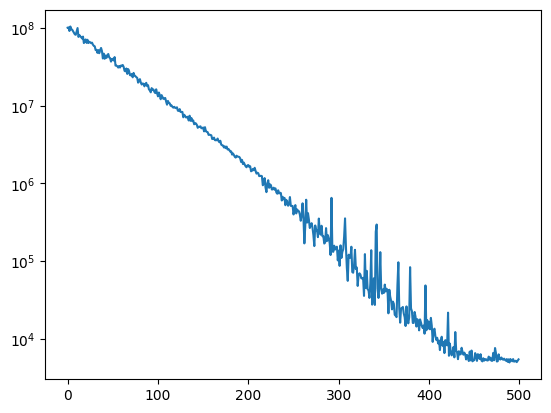

In [67]:
# Variational Inference

import pyro.infer
import pyro.infer.autoguide
import pyro.optim
from pyro.infer.autoguide import init_to_mean

# define the variational distribution - pyro calls it guide
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoMultivariateNormal(
    cantilever_model, init_loc_fn=init_to_mean
)

# Optimization objective: Maximizing the Evidence lower bound (ELBO) implicitly infers the posterior distribution.
# We minimize -log(ELBO), as it is more convenient in optimization to minimize something.
elbo = pyro.infer.JitTrace_ELBO(num_particles=8, max_plate_nesting=1)
svi = pyro.infer.SVI(
    cantilever_model, guide, pyro.optim.ClippedAdam(optim_args={"lr":1e-2}), elbo
)
n_iter = 500
losses = np.zeros(n_iter)
for i in range(n_iter):
    losses[i] = svi.step(mean_length, delta_length, frequencies)
    if i % 100 ==0:
        print(f"i {i:4d}: loss {losses[i]:.4f}")

plt.plot(losses)
plt.yscale("symlog")

# would save parameterized guide (= MultiVariate Normal distribution here)

# Evaluation

In [68]:
# get the posterior density of each parameter independently (marginal posteriors)

idata_mcmc = arviz.from_pyro(mcmc)

vi_posterior_dist = guide.get_posterior()
n_steps = 1000
x = torch.arange(-1, 1, 2 / 1000)
x = (
    vi_posterior_dist.loc.view(-1, 1)
    + 5 * torch.diag(vi_posterior_dist.scale_tril).view(-1, 1) * x
)
x = x.T.detach()
log_p_x = dist.Normal(
    vi_posterior_dist.loc, torch.diag(vi_posterior_dist.scale_tril)
).log_prob(x)  # evaluate each dimension independent
log_p_x.shape

torch.Size([1000, 2])

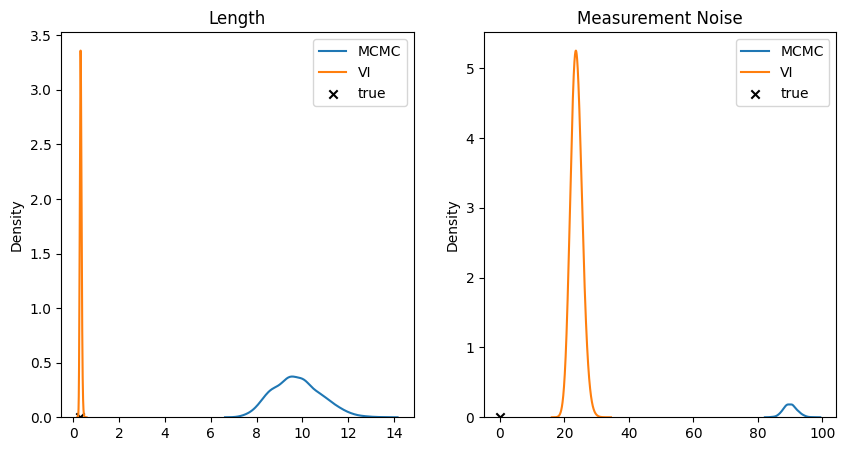

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Length")
sns.kdeplot(np.exp(np.ravel(idata_mcmc.posterior["length"])), ax=axs[0], label="MCMC")
axs[0].plot(x[:,0].detach().exp(), log_p_x[:,0].detach().exp(), label="VI")
axs[0].scatter(length_true, 0, marker="x", label="true", color="black")
axs[0].legend()

axs[1].set_title("Measurement Noise")
sns.kdeplot(np.ravel(idata_mcmc.posterior["measurement_error"]), ax=axs[1], label="MCMC")
axs[1].plot(x[:,1].detach().exp(), log_p_x[:,1].detach().exp(), label="VI")
axs[-1].scatter(
    measurement_noise_true, 0, marker="x", label="true", color="black"
)
axs[-1].legend()

In [70]:
num_predictive_samples = 1000
prior_predictive = pyro.infer.Predictive(
    cantilever_model, num_samples=num_predictive_samples, posterior_samples={}
)
posterior_predictive_mcmc = pyro.infer.Predictive(
    cantilever_model, num_samples=num_predictive_samples, posterior_samples=mcmc.get_samples()
)
posterior_predictive_vi = pyro.infer.Predictive(
    cantilever_model, num_samples=num_predictive_samples, guide=guide
)

prior_predictive_samples = prior_predictive(mean_length, delta_length)
post_predictive_mcmc_samples = posterior_predictive_mcmc(mean_length, delta_length)
post_predictive_vi_samples = posterior_predictive_vi(mean_length, delta_length)

Text(0.5, 0, 'frequency [Hz]')

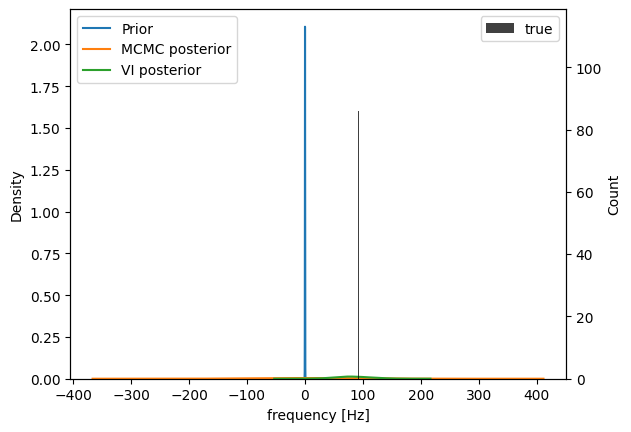

In [71]:
fig, ax = plt.subplots(1,1)
sns.kdeplot(np.ravel(prior_predictive_samples["frequency_obs"]), label="Prior", zorder=2)
sns.kdeplot(np.ravel(post_predictive_mcmc_samples["frequency_obs"]), label="MCMC posterior", zorder=3)
sns.kdeplot(np.ravel(post_predictive_vi_samples["frequency_obs"]), label="VI posterior", zorder=3)
ax2 = ax.twinx()
sns.histplot(frequencies, label="true", color="black", zorder=1, ax=ax2)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
ax.set_xlabel("frequency [Hz]")